In [4]:
# =======================
# 1. IMPORTS
# =======================
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

print("TensorFlow version:", tf.__version__)

# =======================
# 2. DATASET PATH
# =======================
DATASET_PATH = "/kaggle/input/tulu-dataset/final_dataset" 
IMG_SIZE = 64
BATCH_SIZE = 32
SEED = 42

# =======================
# 3. AUTO TRAIN / VAL / TEST SPLIT
# =======================
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2,
    subset="training",
    seed=SEED,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

val_test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.2,
    subset="validation",
    seed=SEED,
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE
)

# Split validation → VAL + TEST (10% + 10%)
val_batches = tf.data.experimental.cardinality(val_test_ds)
test_ds = val_test_ds.take(val_batches // 2)
val_ds = val_test_ds.skip(val_batches // 2)

class_names = train_ds.class_names
NUM_CLASSES = len(class_names)

print("Classes:", NUM_CLASSES)
print("Train batches:", tf.data.experimental.cardinality(train_ds).numpy())
print("Val batches:", tf.data.experimental.cardinality(val_ds).numpy())
print("Test batches:", tf.data.experimental.cardinality(test_ds).numpy())

# =======================
# 4. PERFORMANCE OPTIMIZATION
# =======================
AUTOTUNE = tf.data.AUTOTUNE

normalization_layer = layers.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds   = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds  = test_ds.map(lambda x, y: (normalization_layer(x), y))

train_ds = train_ds.cache().shuffle(2000).prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds  = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# =======================
# 5. HIGH-ACCURACY CNN
# =======================
model = models.Sequential([

    layers.Conv2D(32, 3, activation='relu', padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Conv2D(256, 3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),

    layers.Flatten(),

    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),

    layers.Dense(NUM_CLASSES, activation='softmax')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

# =======================
# 6. CALLBACKS (EarlyStopping REMOVED)
# =======================
callbacks = [
    ReduceLROnPlateau(patience=3, factor=0.3, verbose=1),
    ModelCheckpoint("best_tulu_model.h5", monitor="val_accuracy", save_best_only=True)
]

# =======================
# 7. TRAIN
# =======================
EPOCHS = 60

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks
)

# =======================
# 8. TEST ACCURACY
# =======================
test_loss, test_acc = model.evaluate(test_ds)
print("\n✅ FINAL TEST ACCURACY:", round(test_acc * 100, 2), "%")

# =======================
# 9. SAVE FINAL MODEL
# =======================
model.save("tulu_final_model.keras")

print("\n🎉 TRAINING COMPLETE — MODEL SAVED!")

TensorFlow version: 2.19.0
Found 30000 files belonging to 50 classes.
Using 24000 files for training.
Found 30000 files belonging to 50 classes.
Using 6000 files for validation.
Classes: 50
Train batches: 750
Val batches: 94
Test batches: 94


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 64, 64, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 32, 32, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 16, 16, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 16, 16, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 50)             │        25,650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,515,698 (9.60 MB)

 Trainable params: 2,513,714 (9.59 MB)

 Non-trainable params: 1,984 (7.75 KB)

Epoch 1/60
745/750 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3140 - loss: 2.9955

750/750 ━━━━━━━━━━━━━━━━━━━━ 39s 17ms/step - accuracy: 0.3157 - loss: 2.9870 - val_accuracy: 0.8282 - val_loss: 0.7431 - learning_rate: 3.0000e-04
Epoch 2/60
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.8657 - loss: 0.5369 - val_accuracy: 0.7517 - val_loss: 0.9144 - learning_rate: 3.0000e-04
Epoch 3/60
749/750 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9391 - loss: 0.2620

750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9391 - loss: 0.2620 - val_accuracy: 0.9469 - val_loss: 0.2326 - learning_rate: 3.0000e-04
Epoch 4/60
748/750 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9687 - loss: 0.1290

750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9687 - loss: 0.1290 - val_accuracy: 0.9545 - val_loss: 0.1916 - learning_rate: 3.0000e-04
Epoch 5/60
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9795 - loss: 0.0911

750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9795 - loss: 0.0911 - val_accuracy: 0.9552 - val_loss: 0.1792 - learning_rate: 3.0000e-04
Epoch 6/60
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9866 - loss: 0.0573 - val_accuracy: 0.9499 - val_loss: 0.2292 - learning_rate: 3.0000e-04
Epoch 7/60
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9874 - loss: 0.0514 - val_accuracy: 0.9469 - val_loss: 0.2165 - learning_rate: 3.0000e-04
Epoch 8/60
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9893 - loss: 0.0439
Epoch 8: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9893 - loss: 0.0439 - val_accuracy: 0.9445 - val_loss: 0.2014 - learning_rate: 3.0000e-04
Epoch 9/60
747/750 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9941 - loss: 0.0272

750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9941 - loss: 0.0272 - val_accuracy: 0.9766 - val_loss: 0.0844 - learning_rate: 9.0000e-05
Epoch 10/60
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9960 - loss: 0.0125

750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9960 - loss: 0.0125 - val_accuracy: 0.9776 - val_loss: 0.0845 - learning_rate: 9.0000e-05
Epoch 11/60
748/750 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9970 - loss: 0.0109

750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9970 - loss: 0.0109 - val_accuracy: 0.9779 - val_loss: 0.0893 - learning_rate: 9.0000e-05
Epoch 12/60
748/750 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9974 - loss: 0.0108
Epoch 12: ReduceLROnPlateau reducing learning rate to 2.700000040931627e-05.
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9974 - loss: 0.0108 - val_accuracy: 0.9763 - val_loss: 0.0989 - learning_rate: 9.0000e-05
Epoch 13/60
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9979 - loss: 0.0072

750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9979 - loss: 0.0072 - val_accuracy: 0.9793 - val_loss: 0.0880 - learning_rate: 2.7000e-05
Epoch 14/60
748/750 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9989 - loss: 0.0052

750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9989 - loss: 0.0052 - val_accuracy: 0.9799 - val_loss: 0.0885 - learning_rate: 2.7000e-05
Epoch 15/60
747/750 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9987 - loss: 0.0049
Epoch 15: ReduceLROnPlateau reducing learning rate to 8.100000013655517e-06.
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9987 - loss: 0.0049 - val_accuracy: 0.9796 - val_loss: 0.0900 - learning_rate: 2.7000e-05
Epoch 16/60
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9991 - loss: 0.0038 - val_accuracy: 0.9793 - val_loss: 0.0882 - learning_rate: 8.1000e-06
Epoch 17/60
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9994 - loss: 0.0033 - val_accuracy: 0.9789 - val_loss: 0.0877 - learning_rate: 8.1000e-06
Epoch 18/60
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9996 - loss: 0.0029
Epoch 18: ReduceLROnPlateau reducing learning rate to 2.429999949526973e-06.
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9996 - loss: 

750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.9996 - loss: 0.0027 - val_accuracy: 0.9806 - val_loss: 0.0868 - learning_rate: 2.4300e-06
Epoch 21/60
748/750 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9995 - loss: 0.0029
Epoch 21: ReduceLROnPlateau reducing learning rate to 7.289999985005124e-07.
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9995 - loss: 0.0029 - val_accuracy: 0.9803 - val_loss: 0.0867 - learning_rate: 2.4300e-06
Epoch 22/60
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9992 - loss: 0.0030 - val_accuracy: 0.9796 - val_loss: 0.0874 - learning_rate: 7.2900e-07
Epoch 23/60
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9994 - loss: 0.0028 - val_accuracy: 0.9803 - val_loss: 0.0873 - learning_rate: 7.2900e-07
Epoch 24/60
750/750 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9991 - loss: 0.0029
Epoch 24: ReduceLROnPlateau reducing learning rate to 2.1870000637136398e-07.
750/750 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9991 - loss:

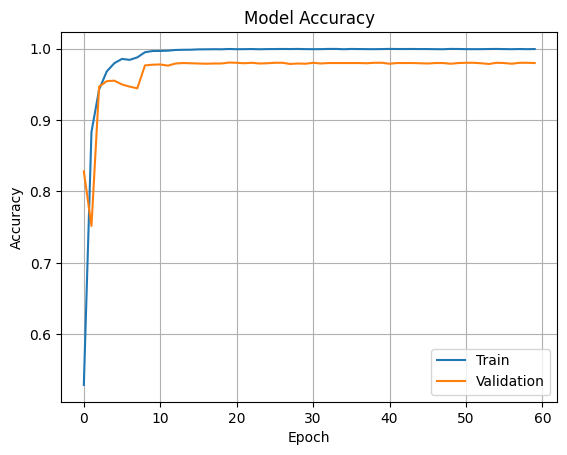

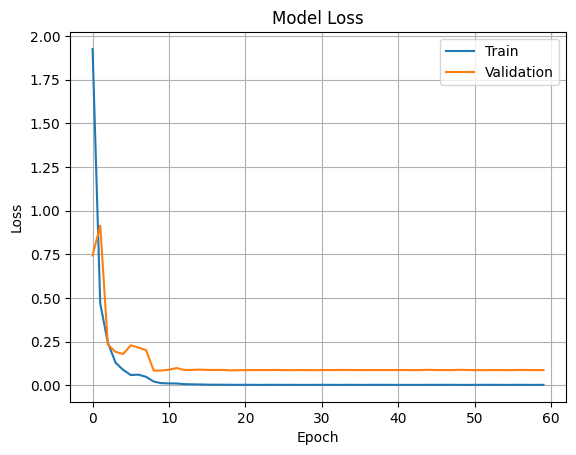

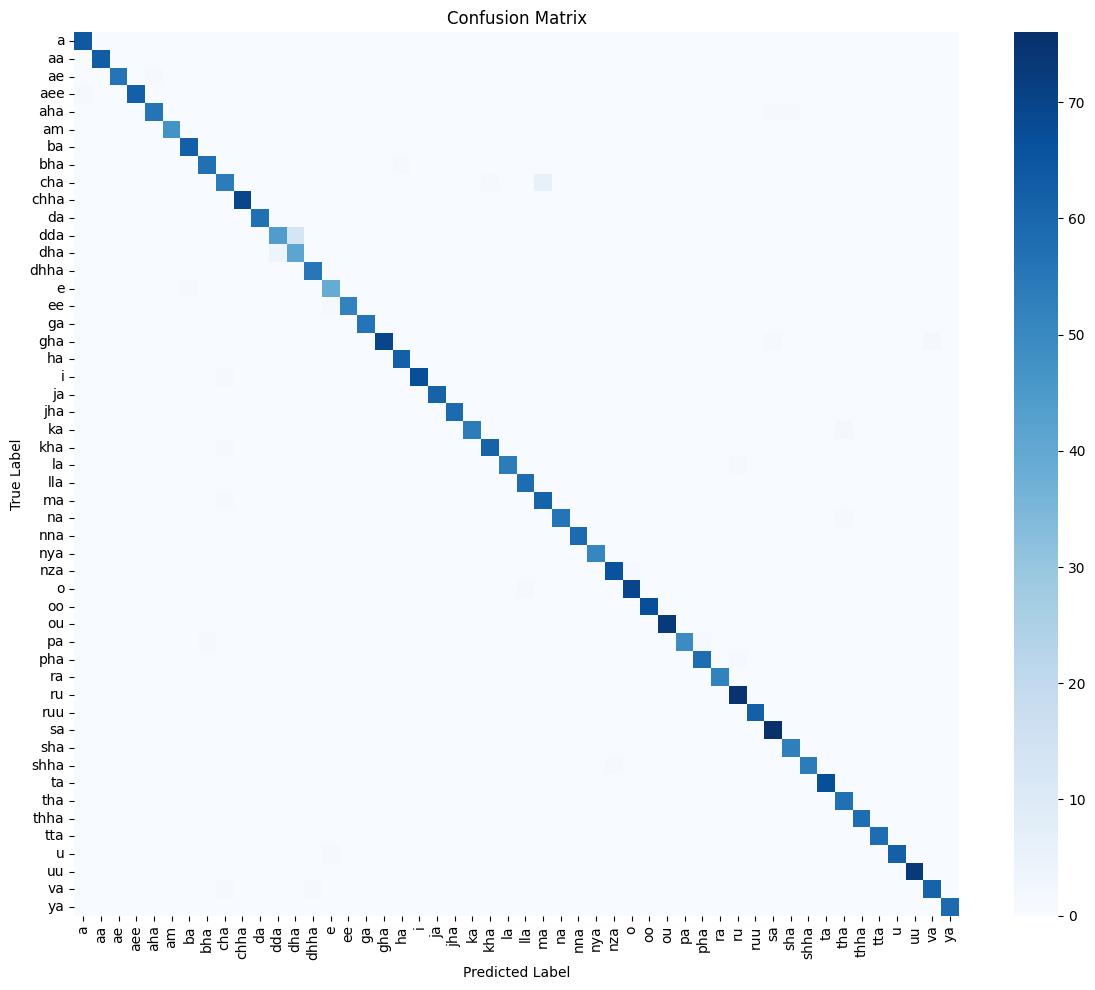


📊 Classification Report:

              precision    recall  f1-score   support

           a       0.98      1.00      0.99        64
          aa       1.00      1.00      1.00        63
          ae       1.00      0.98      0.99        57
         aee       1.00      0.98      0.99        63
         aha       0.98      0.97      0.97        58
          am       1.00      1.00      1.00        47
          ba       0.98      1.00      0.99        62
         bha       0.98      0.98      0.98        58
         cha       0.93      0.89      0.91        61
        chha       1.00      1.00      1.00        70
          da       1.00      1.00      1.00        57
         dda       0.92      0.77      0.84        57
         dha       0.76      0.91      0.83        45
        dhha       0.98      1.00      0.99        55
           e       0.95      0.97      0.96        40
          ee       1.00      0.98      0.99        53
          ga       1.00      1.00      1.00        56


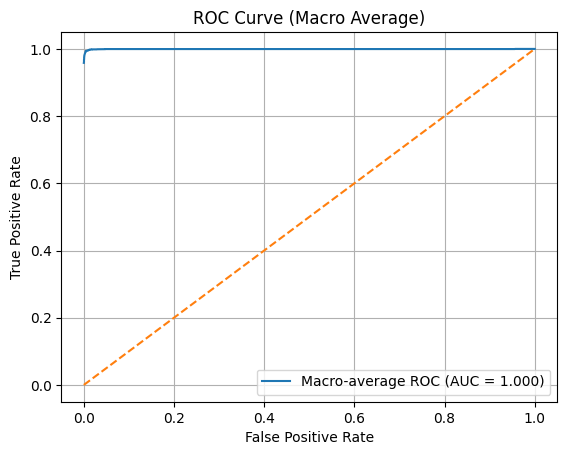

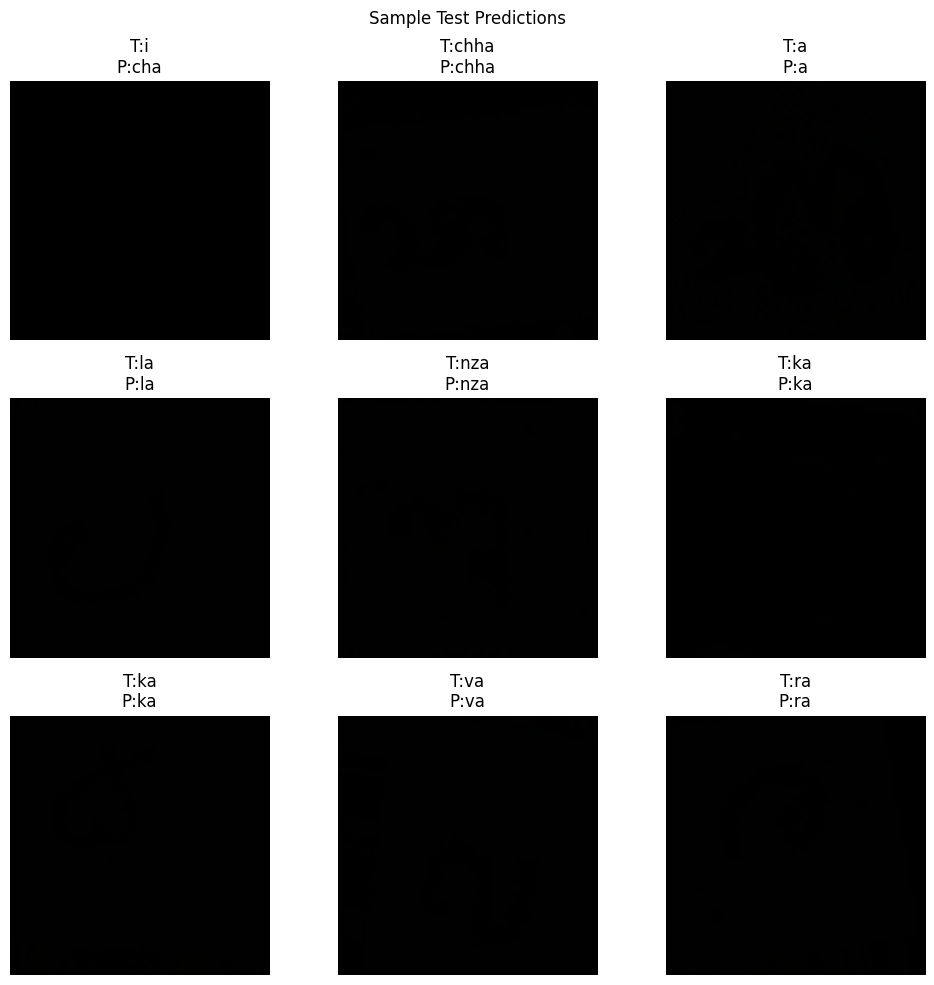


 All evaluation graphs generated successfully!


In [5]:
# ===============================
#  EVALUATION GRAPHS
# ===============================
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
import tensorflow as tf

# -------------------------------
# 1. Accuracy & Loss Curves
# -------------------------------
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.grid(True)
plt.show()

plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.grid(True)
plt.show()


# -------------------------------
# 2. Get Predictions on Test Set
# -------------------------------
y_true = []
y_pred = []
y_prob = []

for images, labels in test_ds:
    probs = model.predict(images, verbose=0)
    preds = np.argmax(probs, axis=1)

    y_true.extend(labels.numpy())
    y_pred.extend(preds)
    y_prob.extend(probs)

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)

class_names = class_names  # from training step
n_classes = len(class_names)


# -------------------------------
# 3. Confusion Matrix
# -------------------------------
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


# -------------------------------
# 4. Classification Report
# -------------------------------
print("\n📊 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


# -------------------------------
# 5. ROC Curve (Macro-Average)
# -------------------------------
y_true_bin = label_binarize(y_true, classes=range(n_classes))

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Macro-average ROC
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
mean_tpr = np.zeros_like(all_fpr)

for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes
roc_auc_macro = auc(all_fpr, mean_tpr)

plt.figure()
plt.plot(all_fpr, mean_tpr, label=f"Macro-average ROC (AUC = {roc_auc_macro:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Macro Average)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


# -------------------------------
# 6. Sample Predictions Visualization
# -------------------------------
plt.figure(figsize=(10, 10))

for images, labels in test_ds.take(1):
    preds = model.predict(images, verbose=0)
    pred_labels = np.argmax(preds, axis=1)

    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"T:{class_names[labels[i]]}\nP:{class_names[pred_labels[i]]}")
        plt.axis("off")

plt.suptitle("Sample Test Predictions")
plt.tight_layout()
plt.show()

print("\n All evaluation graphs generated successfully!")

In [6]:
import numpy as np
from collections import defaultdict

# -------------------------------
# Get predictions on test set
# -------------------------------
y_true = []
y_pred = []

for images, labels in test_ds:
    probs = model.predict(images, verbose=0)
    preds = np.argmax(probs, axis=1)

    y_true.extend(labels.numpy())
    y_pred.extend(preds)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# -------------------------------
# Calculate per-class accuracy
# -------------------------------
class_correct = defaultdict(int)
class_total = defaultdict(int)

for true, pred in zip(y_true, y_pred):
    class_total[true] += 1
    if true == pred:
        class_correct[true] += 1

print("\n Accuracy of Each Alphabet Class:\n")

for i, class_name in enumerate(class_names):
    if class_total[i] == 0:
        acc = 0
    else:
        acc = (class_correct[i] / class_total[i]) * 100

    print(f"{class_name:5s} → {acc:.2f}%   ({class_correct[i]}/{class_total[i]})")


 Accuracy of Each Alphabet Class:

a     → 100.00%   (64/64)
aa    → 100.00%   (63/63)
ae    → 98.25%   (56/57)
aee   → 98.41%   (62/63)
aha   → 96.55%   (56/58)
am    → 100.00%   (47/47)
ba    → 100.00%   (62/62)
bha   → 98.28%   (57/58)
cha   → 88.52%   (54/61)
chha  → 100.00%   (70/70)
da    → 100.00%   (57/57)
dda   → 77.19%   (44/57)
dha   → 91.11%   (41/45)
dhha  → 100.00%   (55/55)
e     → 97.50%   (39/40)
ee    → 98.11%   (52/53)
ga    → 100.00%   (56/56)
gha   → 95.89%   (70/73)
ha    → 100.00%   (62/62)
i     → 98.53%   (67/68)
ja    → 100.00%   (61/61)
jha   → 100.00%   (59/59)
ka    → 96.43%   (54/56)
kha   → 98.39%   (61/62)
la    → 98.18%   (54/55)
lla   → 100.00%   (58/58)
ma    → 98.39%   (61/62)
na    → 98.25%   (56/57)
nna   → 100.00%   (59/59)
nya   → 100.00%   (51/51)
nza   → 98.51%   (66/67)
o     → 98.59%   (70/71)
oo    → 100.00%   (67/67)
ou    → 100.00%   (73/73)
pa    → 96.08%   (49/51)
pha   → 98.31%   (58/59)
ra    → 100.00%   (52/52)
ru    → 100.00%   (75/

In [7]:
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# ---------------------------------------
# Function to get predictions from dataset
# ---------------------------------------
def get_preds(dataset):
    y_true, y_pred = [], []

    for images, labels in dataset:
        probs = model.predict(images, verbose=0)
        preds = np.argmax(probs, axis=1)

        y_true.extend(labels.numpy())
        y_pred.extend(preds)

    return np.array(y_true), np.array(y_pred)


# ---------------------------------------
# Collect predictions
# ---------------------------------------
y_train_true, y_train_pred = get_preds(train_ds)
y_val_true,   y_val_pred   = get_preds(val_ds)
y_test_true,  y_test_pred  = get_preds(test_ds)


# ---------------------------------------
# Per-class metrics function
# ---------------------------------------
def per_class_metrics(y_true, y_pred, num_classes):
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true, y_pred, labels=list(range(num_classes)), zero_division=0
    )

    # Per-class accuracy
    acc = []
    for i in range(num_classes):
        idx = (y_true == i)
        if np.sum(idx) == 0:
            acc.append(0)
        else:
            acc.append(accuracy_score(y_true[idx], y_pred[idx]))

    return np.array(acc), precision, recall, f1


# ---------------------------------------
# Compute metrics
# ---------------------------------------
NUM_CLASSES = len(class_names)

train_acc, train_prec, train_rec, train_f1 = per_class_metrics(
    y_train_true, y_train_pred, NUM_CLASSES
)

val_acc, val_prec, val_rec, val_f1 = per_class_metrics(
    y_val_true, y_val_pred, NUM_CLASSES
)

test_acc, test_prec, test_rec, test_f1 = per_class_metrics(
    y_test_true, y_test_pred, NUM_CLASSES
)


# ---------------------------------------
# Create IEEE-style table
# ---------------------------------------
rows = []

for i, name in enumerate(class_names):
    rows.append([
        name,
        train_acc[i]*100, val_acc[i]*100, test_acc[i]*100,
        test_prec[i]*100, test_rec[i]*100, test_f1[i]*100
    ])

df = pd.DataFrame(rows, columns=[
    "Alphabet",
    "Train Acc (%)",
    "Val Acc (%)",
    "Test Acc (%)",
    "Precision (%)",
    "Recall (%)",
    "F1-Score (%)"
])

# ---------------------------------------
# Print nicely
# ---------------------------------------
print("\nPER-ALPHABET METRICS (IEEE-READY)\n")
print(df.round(2).to_string(index=False))


# ---------------------------------------
# Save to CSV for paper table
# ---------------------------------------
df.to_csv("tulu_per_class_metrics.csv", index=False)

print("\n Saved as: tulu_per_class_metrics.csv")


PER-ALPHABET METRICS (IEEE-READY)

Alphabet  Train Acc (%)  Val Acc (%)  Test Acc (%)  Precision (%)  Recall (%)  F1-Score (%)
       a         100.00        98.18        100.00          98.46      100.00         99.22
      aa         100.00       100.00        100.00         100.00      100.00        100.00
      ae         100.00        98.33         98.25         100.00       98.25         99.12
     aee         100.00       100.00         98.41         100.00       98.41         99.20
     aha         100.00        98.21         96.55          98.25       96.55         97.39
      am         100.00        98.41        100.00         100.00      100.00        100.00
      ba         100.00        97.92        100.00          98.41      100.00         99.20
     bha         100.00        98.51         98.28          98.28       98.28         98.28
     cha          98.74        98.39         88.52          93.10       88.52         90.76
    chha         100.00        98.33        

In [8]:
class EpochHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.train_preds = []
        self.val_preds = []

    def on_epoch_end(self, epoch, logs=None):
        # collect predictions for train and val each epoch
        def get_preds(dataset):
            y_true, y_pred, y_prob = [], [], []
            for images, labels in dataset:
                probs = self.model.predict(images, verbose=0)
                preds = np.argmax(probs, axis=1)
                y_true.extend(labels.numpy())
                y_pred.extend(preds)
                y_prob.extend(np.max(probs, axis=1))
            return np.array(y_true), np.array(y_pred), np.array(y_prob)

        self.train_preds.append(get_preds(train_ds))
        self.val_preds.append(get_preds(val_ds))


epoch_history = EpochHistory()

In [9]:
callbacks = [
    ReduceLROnPlateau(patience=3, factor=0.3, verbose=1),
    ModelCheckpoint("best_tulu_model.h5", monitor="val_accuracy", save_best_only=True),
    epoch_history
]

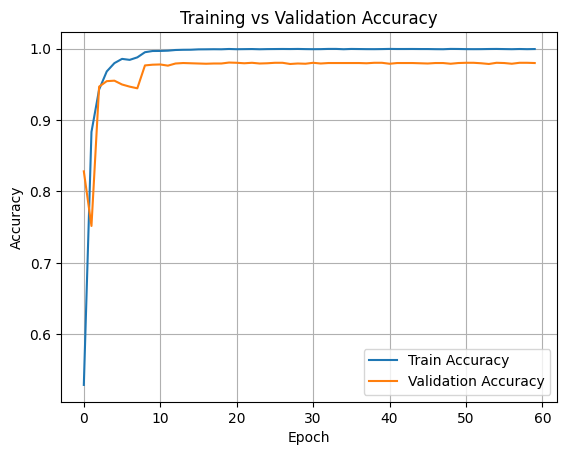

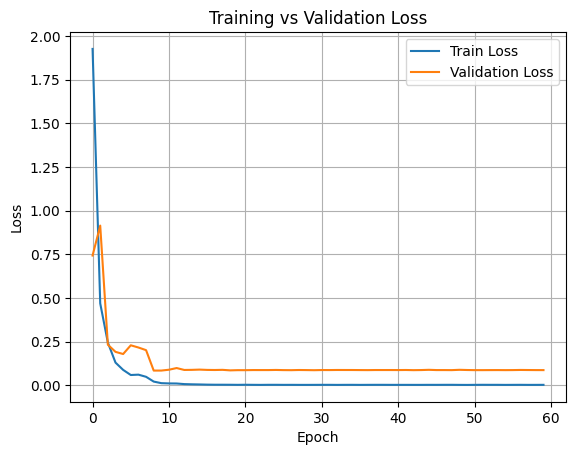

In [11]:
import matplotlib.pyplot as plt

# -----------------------
# Accuracy graph
# -----------------------
plt.figure()
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()


# -----------------------
# Loss graph
# -----------------------
plt.figure()
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

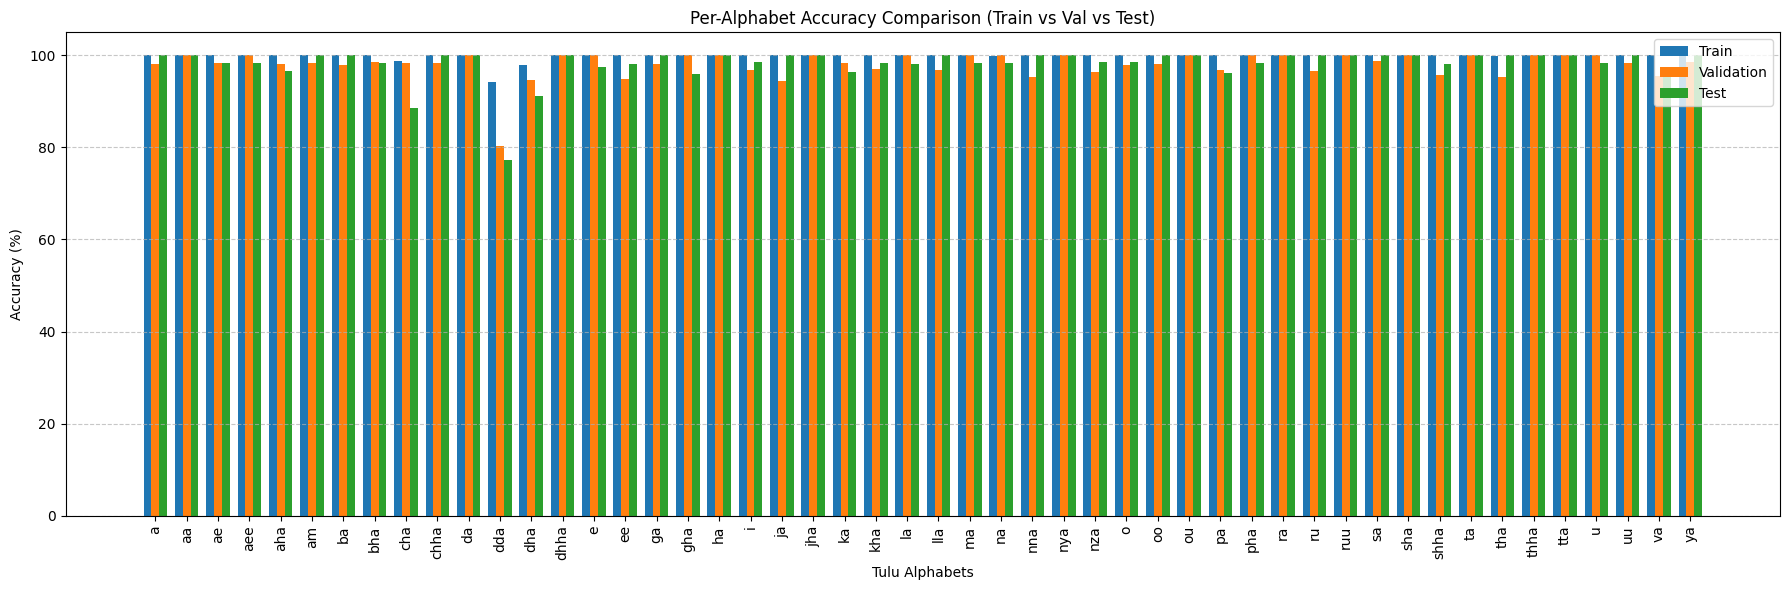

In [12]:
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(len(class_names))  # alphabet positions
width = 0.25

plt.figure(figsize=(18, 6))

plt.bar(x - width, train_acc * 100, width, label="Train")
plt.bar(x,         val_acc * 100,   width, label="Validation")
plt.bar(x + width, test_acc * 100,  width, label="Test")

plt.xlabel("Tulu Alphabets")
plt.ylabel("Accuracy (%)")
plt.title("Per-Alphabet Accuracy Comparison (Train vs Val vs Test)")
plt.xticks(x, class_names, rotation=90)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

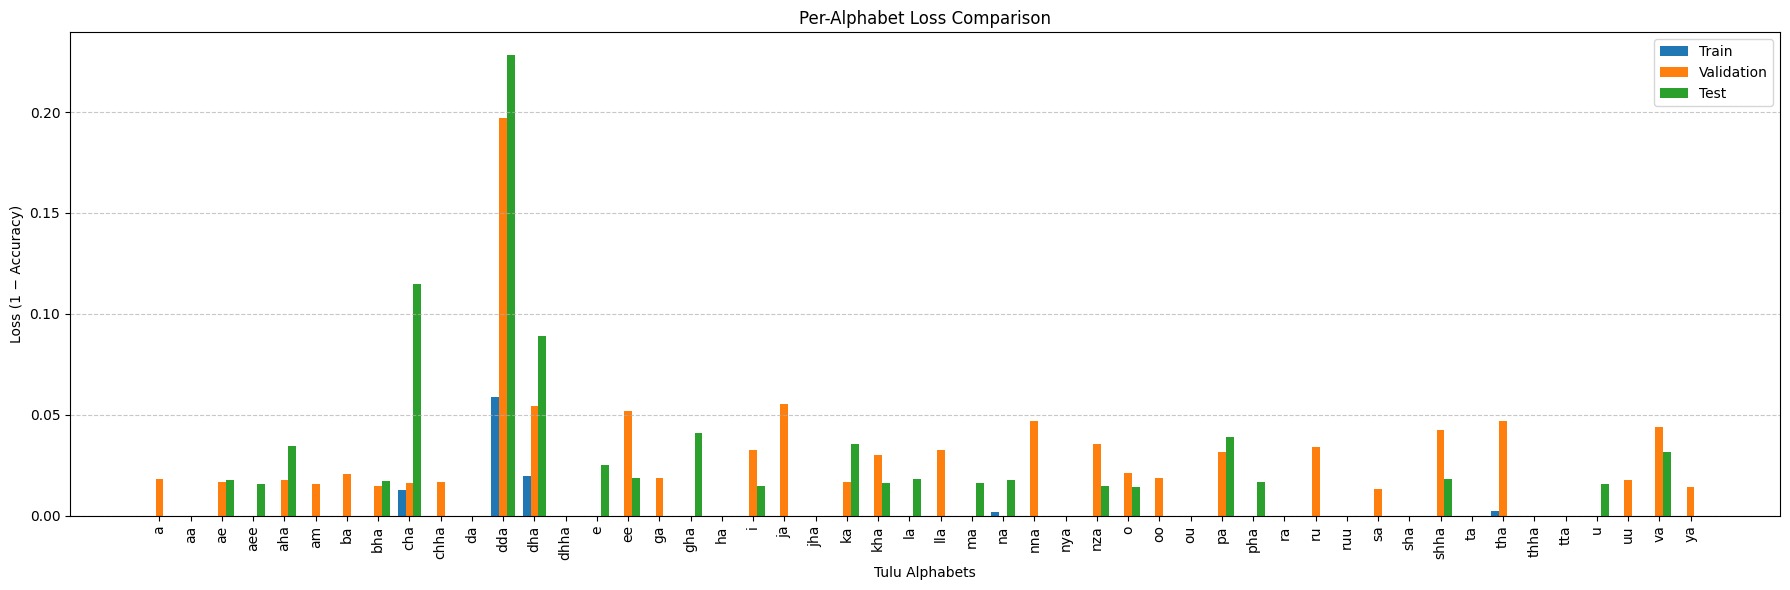

In [13]:
train_loss_pc = 1 - train_acc
val_loss_pc   = 1 - val_acc
test_loss_pc  = 1 - test_acc

plt.figure(figsize=(18, 6))

plt.bar(x - width, train_loss_pc, width, label="Train")
plt.bar(x,         val_loss_pc,   width, label="Validation")
plt.bar(x + width, test_loss_pc,  width, label="Test")

plt.xlabel("Tulu Alphabets")
plt.ylabel("Loss (1 − Accuracy)")
plt.title("Per-Alphabet Loss Comparison")
plt.xticks(x, class_names, rotation=90)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

In [17]:
from sklearn.metrics import accuracy_score
import numpy as np

# -----------------------------
# Function to get predictions
# -----------------------------
def get_preds(dataset):
    y_true, y_pred = [], []

    for images, labels in dataset:
        probs = model.predict(images, verbose=0)
        preds = np.argmax(probs, axis=1)

        y_true.extend(labels.numpy())
        y_pred.extend(preds)

    return np.array(y_true), np.array(y_pred)


# -----------------------------
# Get predictions for each split
# -----------------------------
y_train_true, y_train_pred = get_preds(train_ds)
y_val_true,   y_val_pred   = get_preds(val_ds)
y_test_true,  y_test_pred  = get_preds(test_ds)


# -----------------------------
# Compute overall accuracies
# -----------------------------
train_acc = accuracy_score(y_train_true, y_train_pred) * 100
val_acc   = accuracy_score(y_val_true,   y_val_pred) * 100
test_acc  = accuracy_score(y_test_true,  y_test_pred) * 100


# -----------------------------
# Print results (IEEE style)
# -----------------------------
print("\n OVERALL MODEL ACCURACY\n")
print(f"Training Accuracy   : {train_acc:.2f}%")
print(f"Validation Accuracy : {val_acc:.2f}%")
print(f"Test Accuracy       : {test_acc:.2f}%")


 OVERALL MODEL ACCURACY

Training Accuracy   : 99.81%
Validation Accuracy : 97.99%
Test Accuracy       : 98.34%
